<a href="https://colab.research.google.com/github/knobelsp/BlandAltman/blob/main/BlandAltman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A statistically sound method to test data against a reference





**We've all done it...
that is, tested our dataset / algorithm output / etc. against a reference with a simple $x$ vs $y$ scatterplot**.
Perhaps we fit a line to the results, or calculated the correlation coefficient. 

*But is this really the right way to test how our data compares to a reference?* 

**The answer is no**, and there is substantial literature to support this (e.g.
<a href="https://doi.org/10.1364/OE.26.007404">Seegers et al., 2018</a>). But that doesn't stop many of us from making a simple plot, calculating default statistics and calling it a day. Perhaps our motivation is the perceived approachability and simplicity. Maybe we're not aware of the statistical unsuitability. Or maybe we calculated a correlation of 0.97, and that sounds good enough, right?
 

## This notebook demonstrates simple alternatives: Bland-Altman plots and corresponding metrics

**The fundamental problem we're addressessing is "can measurement $y$ replace measurement $x$".** For example, we might have geophysical parameters retreived from an analysis of satellite data that we're comparing to ground based measurements, or results of a trained neural network that we wish to assess against independent validation data. In these cases, we have paired measurements, ie $[(x_1,y_1),(x_2,y_2),(x_3,y_3),...]$, that we would like to assess in aggregate. No single numerical metric can wholly express the 'quality' of the comparison. We instead need several metrics, such as:
 - mean bias between $x$ and $y$
 - scatter in the relationship between $x$ and $y$
 - scale dependence of bias and scatter

While all of these things can be visually inferred from a scatterplot, they are more directly expressed with a *Bland-Altman plot* and corresponding metrics. These techniques are described in <a href="https://doi.org/10.2307/2987937">Altman and Bland, 1983</a>, <a href="https://doi.org/10.1016/S0140-6736(86)90837-8">Bland and Altman, 1986</a> and many subsequent publications (e.g. <a href="https://dx.doi.org/10.1016/j.ijnurstu.2009.10.001">Bland and Altman, 2010</a>, 
<a href="https://doi.org/10.1093/clinchem/48.5.799">Dewitte et al., 2002</a>). An alternative name for this approach is the *Tukey mean-difference plot* and other field specific names, and there is ample evidence of similar analysis that predates Bland and Altman's highly cited papers (e.g. <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.632.3728&rep=rep1&type=pdf">Eksborg, 1981</a>). 

As we will demonstrate, $x$ vs. $y$ scatterplots are less effecive at assessing agreement between a pair of measurement types than a Bland-Altman plot. Even more problemmatic are the statistical metrics that are often used in conjunction, including:
 - linear regression (i.e. y = mx +b fits)
 - correlation coefficients (such as the Pearson' linear or the Spearman's rank correlation coefficients)
 - root mean square error (RMSE)
 
The abovementioned literature discusses the inadaquacy of these metrics. **Instead, this notebook is intended to be a graphical demonstration of the advantages of the Bland-Altman approach, with side by side comparisons of various datasets.**

### Before starting, compile this code...

In [5]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from collections import namedtuple


In [4]:
#Routine to plot, side by side, 2D histograms of paired data as bland-altman and scatterplot. 
#It also calculates relevant analysis metrics.
#Takes as input:
# x_input: array of X data values
# y_input: corresponding array of Y data values, ie [X[1],Y[1]]. len(x_input)=len(y_input)
# label: text label for plotting, default is emtpy ('')
# saveplot: set to 1 to save plot, default is (0)
# scat: default (0) is to make a 2d histogram, regular scatterplot if set to 1
# binscale: default (1) is a scaling factor for how many bins to include in a 2d histogram
#Returns:
# scaleindependence: binary result of test for scale independence
# meanbias: mean bias (NaN if not scale independent)
# loa: one sigma Limits of agreement ([NaN,NaN] if not scale independent)
# linregress: linear regression of x vs y, [slope,intercept]
# lincorr: linear correlation (pearson rho)
# rankcorr: rank correlation (spearman rho)

def plot_BAvsScat(x_input,y_input,label='',saveplot=0, scat=0, binscale=1.0):
    #deal with inputs
    xx=np.asarray(x_input)
    yy=np.asarray(y_input)
    
    #compute Bland-Altman axes
    jj=(xx+yy)/2  #paired mean
    kk=yy-xx      #bias

    #compute Bland-Altman metrics
    meanbias=np.mean(kk)
    stdbias=np.std(kk)
    LOAlow= meanbias - stdbias #lower limit of agreement (LOA)
    LOAhgh= meanbias + stdbias #upper limit of agreement (LOA)

    #stuff to make plotting nice  
    nbin=int(0.5*binscale*np.sqrt(len(xx))) #find appropriate binning dimensions, relevant for 2dhist
    min_kk=meanbias - 5.*(stdbias)
    max_kk=meanbias + 5.*(stdbias) 
    
    if scat == 0:
        jj_sorted= np.sort(jj)  # sort paired mean data in ascending order
        min_jj=jj_sorted[int(0.01*len(xx))]
        max_jj=jj_sorted[int(0.99*len(xx))]
    else:
        min_jj=min(jj)
        max_jj=max(jj)
    gamma=0.5

    #check for bland-altman bias scale independence
    ba_stat, ba_p = stats.spearmanr(jj, kk)
    ba_independ = ba_p > 0.05 #check that the p-value is greater than 0.05
    if ba_independ:
        print('Bias INDEPENDENT of paired mean, r:%.3f' % ba_stat)
    else:
        print('Bias DEPENDENT on paired mean, r:%.3f' % ba_stat)
        ba_regress_result=stats.linregress(jj,kk)
        ba_min_fit_yy=ba_regress_result.slope*min_jj + ba_regress_result.intercept
        ba_max_fit_yy=ba_regress_result.slope*max_jj + ba_regress_result.intercept

    #compute scatterplot regression metrics
    regress_result=stats.linregress(xx, yy)
    spearman_r=stats.spearmanr(xx,yy)
    r_spear=round((spearman_r.correlation)*10000)/10000.
    pearson_r=stats.pearsonr(xx,yy)
    r_pear=round((pearson_r[0])*10000)/10000.
    
    #set up colors
    if scat == 0:
        lineclr='white'
        loaclr='yellow'
        fitclr='cyan'
    else: 
        lineclr='black'
        loaclr='green'
        fitclr='magenta'
    
    #make nice labels for plotting
    #...for Bland-Altman
    meanbias=round(meanbias*100000)/100000.
    LOAlow=round(LOAlow*10000)/10000.
    LOAhgh=round(LOAhgh*10000)/10000.  
    ba_rankcorr=round((ba_stat)*10000)/10000.
    if ba_independ:
        txt1='Mean bias: '+str(meanbias)+' ('+fitclr+' dashed line)'
        txt2='LOA: ['+str(LOAlow)+','+str(LOAhgh)+'] ('+loaclr+' dashed lines)'
    else:
        txt1='Bias DEPENDENT on paired mean (magenta is linear fit)'
        txt2='Rank correlation: '+str(ba_rankcorr)
        
    #...regression
    slope=round(regress_result.slope*10000)/10000.
    intercept=round(regress_result.intercept*10000)/10000.
    txt3='y = '+str(slope)+'x + '+str(intercept)+' ('+fitclr+' dashed line)'
    txt4='Linear correlation: '+str(r_pear)
    txt5='Rank correlation: '+str(r_spear)
       
    #plotting setup
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
    fig.suptitle(label, fontsize=22)    
    
    #plot bland-altman
    if scat == 0:
        h=ax1.hist2d(jj,kk, bins=(nbin,nbin), norm=mcolors.PowerNorm(gamma), cmap=plt.cm.inferno,
                   range=[[min_jj, max_jj], [min_kk, max_kk]])

        fig.colorbar(h[3], ax=ax1)
    else:
        h=ax1.scatter(jj,kk)
        ax1.set_xlim([min_jj, max_jj])
        ax1.set_ylim([min_kk, max_kk])

    ax1.set_title('Bland-Altman plot', fontsize=20)
    ax1.set_xlabel('Paired mean, $(x+y)/2$', fontsize=18)
    ax1.set_ylabel('Bias, $y-x$', fontsize=18)
    
    ax1.plot([min_jj,max_jj],[0,0],color=lineclr,linestyle='solid',linewidth=4.0)
    if ba_independ:
        ax1.plot([min_jj,max_jj],[meanbias,meanbias],color=fitclr,linestyle='dashed',linewidth=3.0)
        ax1.plot([min_jj,max_jj],[LOAlow,LOAlow],color=loaclr,linestyle='dashed',linewidth=2.0)
        ax1.plot([min_jj,max_jj],[LOAhgh,LOAhgh],color=loaclr,linestyle='dashed',linewidth=2.0)
    else:
        ax1.plot([min_jj,max_jj],[ba_min_fit_yy,ba_max_fit_yy],color=fitclr,linestyle='dashed',linewidth=3.0)
    ax1.text(0.04, 0.95, txt1, horizontalalignment='left', color=lineclr,verticalalignment='center', 
             transform=ax1.transAxes,fontsize=12)
    ax1.text(0.04, 0.90, txt2, horizontalalignment='left', color=lineclr,verticalalignment='center', 
             transform=ax1.transAxes,fontsize=12)   

    #make scatterplot
    if scat == 0:
        g=ax2.hist2d(xx,yy, bins=(nbin,nbin), norm=mcolors.PowerNorm(gamma), cmap=plt.cm.inferno,
               range=[[min_jj, max_jj], [min_jj, max_jj]])
        fig.colorbar(g[3], ax=ax2)
        xax_move=0.3
    else:
        g=ax2.scatter(xx,yy)
        ax2.set_xlim([min_jj, max_jj])
        ax2.set_ylim([min_jj, max_jj])
        xax_move=0.0
        
    ax2.set_title('Scatterplot', fontsize=20)
    ax2.set_xlabel('$x$', fontsize=18)
    ax2.set_ylabel('$y$', fontsize=18)
    ax2.plot([min_jj,max_jj],[min_jj,max_jj],color=lineclr,linestyle='solid',linewidth=4.0)

    #find regression line
    min_fit_yy=regress_result.slope*min_jj + regress_result.intercept
    max_fit_yy=regress_result.slope*max_jj + regress_result.intercept
    ax2.plot([min_jj,max_jj],[min_fit_yy,max_fit_yy],color=fitclr,linestyle='dashed',linewidth=3.0)
    ax2.text(xax_move+1.24, 0.95, txt3, horizontalalignment='left', color=lineclr,
             verticalalignment='center', transform=ax1.transAxes,fontsize=12)
    ax2.text(xax_move+1.24, 0.90, txt4, horizontalalignment='left', color=lineclr,
             verticalalignment='center', transform=ax1.transAxes,fontsize=12)
    ax2.text(xax_move+1.24, 0.85, txt5, horizontalalignment='left', color=lineclr,
             verticalalignment='center', transform=ax1.transAxes,fontsize=12)   

    #save figure if savefig=1
    if saveplot == 1:
        figname=label+"_blandaltman.pdf"
        print('Saved figure to:',figname)
        fig.savefig(figname)

    #violà!
    plt.show()

    #return data

    if ba_independ:
        loa=(LOAlow,LOAhgh)
    else:
        loa=(float("NAN"),float("NAN")) 
        meanbias=float("NAN")

    output = namedtuple("BlandAltman", ["scaleindependence","meanbias","loa","linregress","lincorr","rankcorr"])
    return output(
        ba_independ,
        meanbias,
        loa,
        (regress_result.slope,regress_result.intercept),
        r_pear,
        r_spear,
    )


### The Bland-Altman technique

The Bland-Altman plot differs from a regular scatterplot in that the bias between each pair of measurements is graphed against the paired mean. Rather than plotting $x$ versus $y$ for paired measurements $[(x_1,y_1),(x_2,y_2),(x_3,y_3),...]$, we instead calculate the paired mean ($m_i$) and bias ($b_i$):

$m_i = \frac{x_i+y_i}{2}$

$b_i = y_i - x_i $

Thus, the Bland-Altman plot represents $m$ versus $b$. While this contains the same information as the scatterplot, it clearly and independently visualizes the most relevant and robust metrics for comparisons of measurement techniques: bias, scatter, and scale dependence.

We'll describe those in detail in a moment, but for now let's start with a simple example based on randomly generated numbers. 


Bias INDEPENDENT of paired mean, r:-0.069


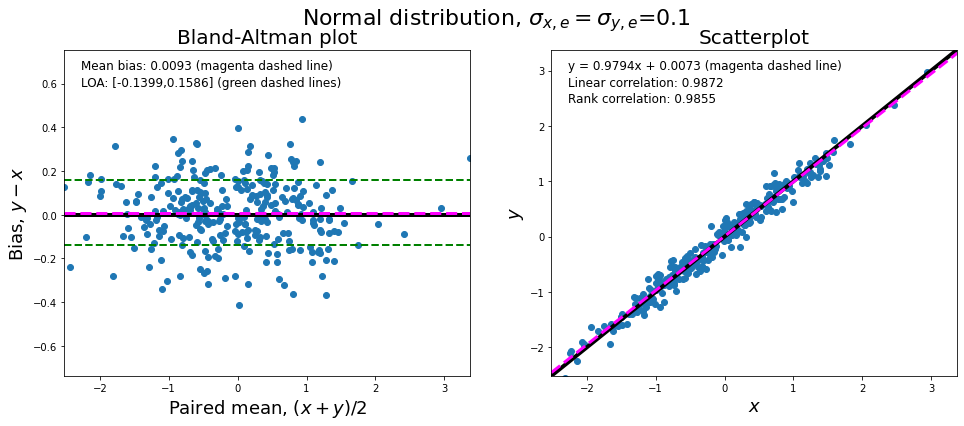

In [6]:
leng=300 #this is how many data points will be in the example
source=np.random.standard_normal(size=(leng)) #this is the true value
random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus random errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy= source + yy_error_rand #y is the true value (source) plus random errors

ba_norm_nobias=plot_BAvsScat(xx,yy,label='Normal distribution, $\sigma_{x,e}=\sigma_{y,e}$=0.1',scat=1)

Above, we show the Bland-Altman plot at left and a standard scatterplot at right. The source data are randomly selected from a zero mean, $\sigma$=1 Gaussian normal distribution. 'Measurements' of these data, expressed in $x$ and $y$, include random errors from a zero mean normal distribution with $\sigma_e$=0.1.

$x$ and $y$ represent different measurement systems with (only) random errors for each observation. The mean of the $y-x$ bias is therefore close to zero. This is clear in the Bland-Altman plot, where it has been labeled with a dashed magenta line. It is also shown in the scatterplot at right, and in the linear fit to the data (also a magenta dashed line) which is close to $y = 1.0x + 0.0$. Both the linear (Pearson) and rank (Spearman) correlation coefficients are 'high', although it is difficult to connect the specific meaning of those values to the data itself. The **mean bias, $\bar{b}$**, on the other hand, is a metric expressed in the units of the measurement, and clearly shown in the Bland-Altman plot. 

A significant difference between the Bland-Altman plot and scattplot is how random errors (scatter) are represented. It is readily apparent in the Bland-Altman plot. The amount of this scatter can be exprssed with the **Limits of Agreement, LOA**:

$LOA = [\bar{b}-s, \bar{b}+s]$

where $s$ is the standard deviation of $b$. Here, we're using a one sigma basis for LOA, although some define it at two sigma or other multiples of $s$. In the example above, LOA approximately represents $\pm$ the squared sum of the $\sigma_e$ random errors for $x$ and $y$ (with no bias). 

**The LOA expresses expectations of agreement between $x$ and $y$. When it is defined at one sigma, we can expect the $y-x$ difference to fall within this range roughly 68.2% of the time** (see below for further qualifications regarding scale dependence).

Like $\bar{b}$, the LOA has the same units as the measurement. There is no equivalent in a scatterplot, linear regression to $x$ and $y$, or correlation coefficients. The latter are, of course, close to 1 for minimal bias and scatter systems, but multiple factors can cause the correlation coefficient to decrease. 


### Example with random and systemmatic errors

Next, we'll demonstrate the case where one of the measurement systems ($y$) has both random and systemmatic errors. 

Bias INDEPENDENT of paired mean, r:-0.011


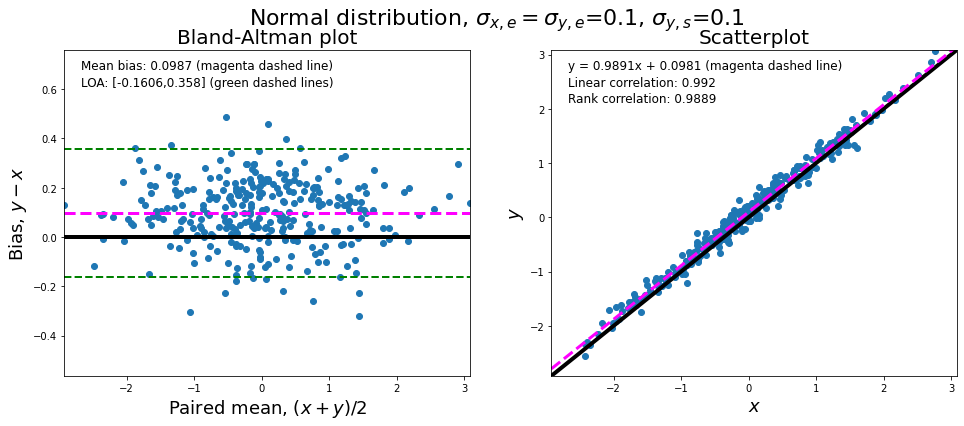

In [ ]:
leng=300
source=np.random.standard_normal(size=(leng)) #this is the true value
random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_norm_bias=plot_BAvsScat(xx,yy,label='Normal distribution, $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$=0.1',scat=1)

In this case we can see the advantage of the Bland-Altman style plot and analysis, as the bias of $y$ compared to $x$ is clearly present (note the automatically adjusting axis range in our plotting function), and the observed $\bar{b} \approx \sigma_{y,s} - \sigma_{x,s} = 0.1$. The LOA range is similar to that of the previous example, but shifted by the amount of $\bar{b}$. 

Although random and systemmatic errors are equivalent in magnitude, the scatterplot appears nearly identical to the previous example, which had no systemmatic error. The only indication of systemmatic error is expressed in the linear regression y intercept. 

### Example with non-normal numerical distributions

Non-Gaussian normal numerical distributions can impact the robustness of regression and correlation metrics. Unfortunately, our data frequently have non-Gaussian distributions. Here we give examples of the impacts of different distributions.

Bias INDEPENDENT of paired mean, r:0.007


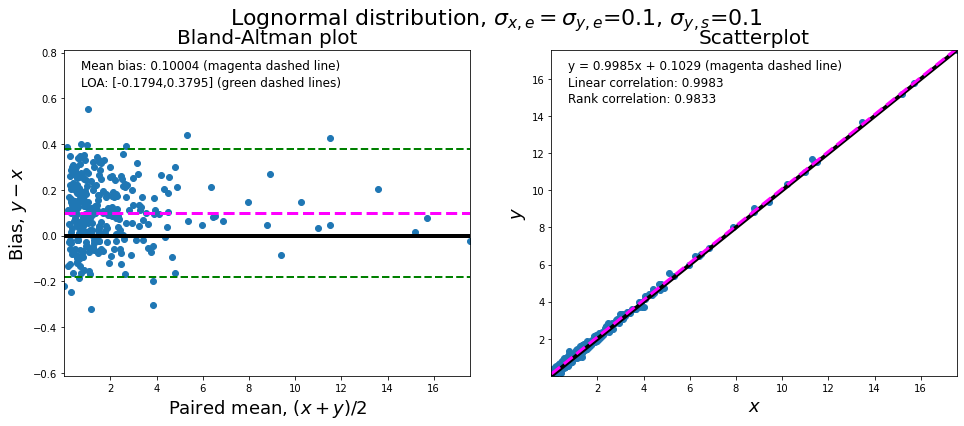

In [ ]:
leng=300
source=np.random.lognormal(0.1,1,size=(leng)) #this is the true value
random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_lognorm_bias=plot_BAvsScat(xx,yy,label='Lognormal distribution, $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$=0.1',scat=1)

Bias INDEPENDENT of paired mean, r:-0.093


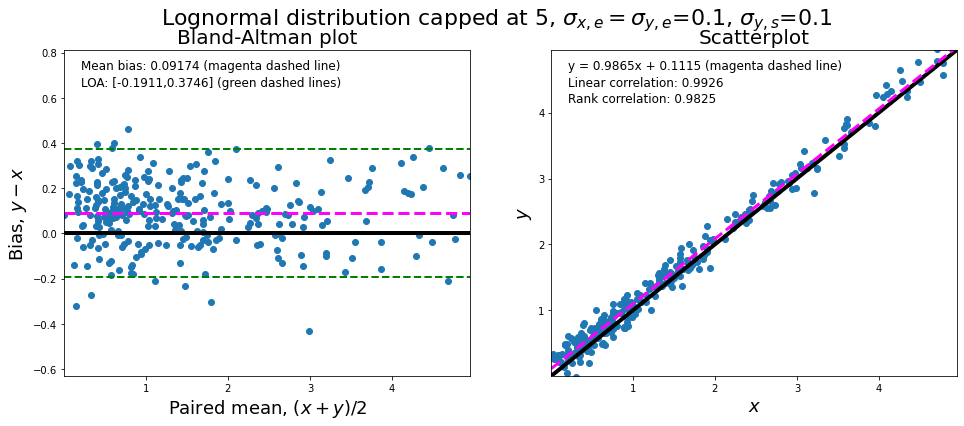

In [ ]:
leng=300
source=np.random.lognormal(0.1,1,size=(leng)) #this is the true value
source=source[source <=5] #cap source data at 3
leng=len(source)

random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_lognormcap_bias=plot_BAvsScat(xx,yy,label='Lognormal distribution capped at 5, $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$=0.1',scat=1)

Bias INDEPENDENT of paired mean, r:0.028


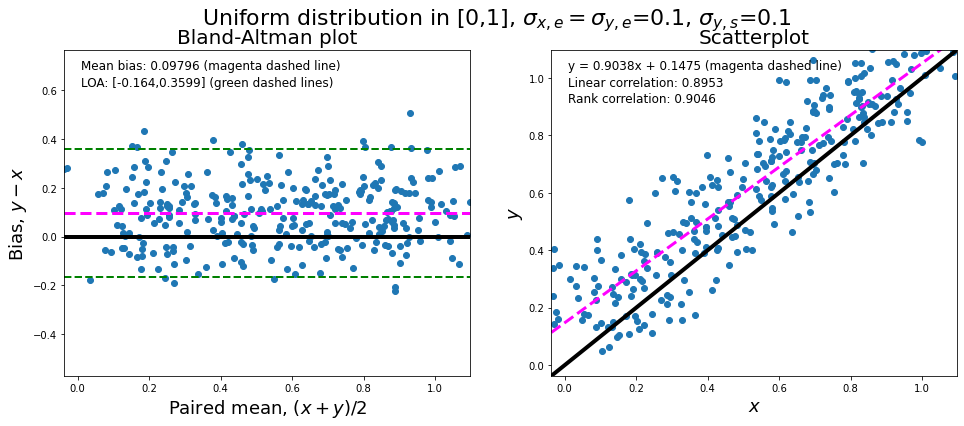

In [ ]:
leng=300
source=np.random.uniform(0,1,size=(leng)) #this is the true value
random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_uniform_bias=plot_BAvsScat(xx,yy,label='Uniform distribution in [0,1], $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$=0.1',scat=1)

We've plotted the results of data with three numerical distributions commonly encountered in the remote sensing validation community: 

 - lognormal distributions (encountered with atmospheric *Aerosol Optical Thickness (AOT)* (<a href="https://doi.org/10.5194/acp-19-15023-2019">Sayer and Knobelspiesse, 2019</a>) or oceanic *Chlorophyll-a* concentration (<a href="https://doi.org/10.1029/95JC00458">Campbell, 1995</a>))
 - capped lognormal distributions (due to algorithm pre-screening such as the case when high *AOT* is misinterpretated as a cloud), and
 - uniform distributions in the $[0,1]$ range, for fractional concentrations of geophysical parameters.

The derived statistical metrics for these three cases (and our particular random number generator seed) were:

Distribution | Mean Bias, $\bar{b}$ | LOA            | Regression | Linear r  | Rank r
-------------|-----------|----------------|------------|-----------|-------
Normal       | 0.1089    | [-0.030,0.248] | y=0.993x+0.109 | 0.989 | 0.987
Lognormal    | 0.1045    | [-0.039,0.248] | y=0.995x+0.113 | 0.998 | 0.971
Lognormal, capped| 0.0947    | [-0.039,0.228] | y=0.993x+0.104 | 0.992 | 0.983
Uniform      | 0.1025    | [-0.038,0.243] | y=0.895x+0.154 | 0.901 | 0.907

While the mean bias and LOA are insensitive to these different numerical distributions, the regression and correlation coefficients are not. This is especially obvious for the uniform distribution, for which a regression consistently underestimates the slope and overestimates the y-intercept. Correlation coefficients for the lognormal capped and uniform distributions are less than that for other distributions, which would lead to an interpretation of diminished agreement between measurement methods, when in fact nothing has changed about the measurement system. 


### Systemmatic error scale dependence

The examples we've investigated so far had systemmatic errors that did not depend on the magnitude of the source data. If instead this is the case, none of the statistical metrics presented above are particularly meaningful. However, the Bland-Altman plot clearly visualizes when that is so. Additionally, a simple hypothesis test can be performed for additional verification. Here, we show examples of a scale dependent bias, and how it is expressed with a Bland-Altman plot and a scatterplot.

Bias DEPENDENT on paired mean, r:0.541


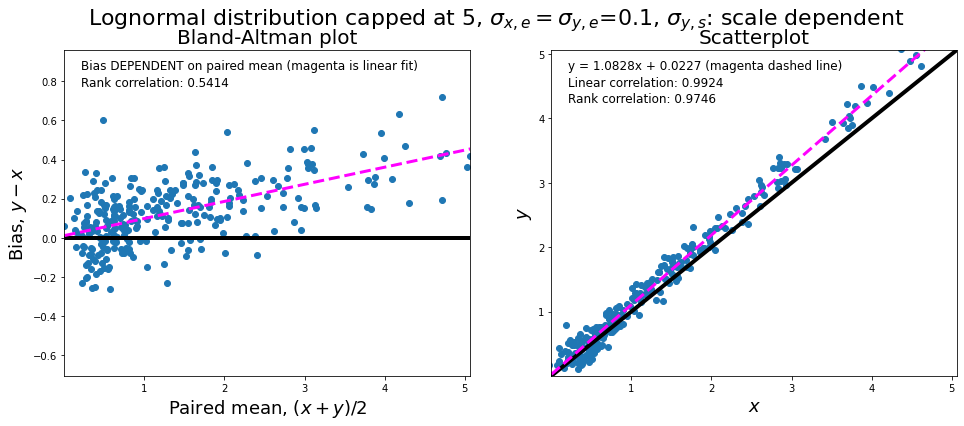

BlandAltman(scaleindependence=False, meanbias=0.12815, loa=(nan, nan), linregress=(1.0827655936301488, 0.0226843489491928), lincorr=0.9924, rankcorr=0.9746)

In [ ]:
leng=300
#source=np.random.standard_normal(size=(leng)) #this is the true value


source=np.random.lognormal(0.1,1,size=(leng)) #this is the true value
source=source[source <=5] #cap source data at 3
leng=len(source)

random_error=0.1 #set a random error of 10% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy_error_syst= 0.1 * source #systemmatic error for measurement y
yy= source + yy_error_rand + yy_error_syst #y is the true value (source) plus  errors

ba_lognormcap_scalebias=plot_BAvsScat(xx,yy,label='Lognormal distribution capped at 5, $\sigma_{x,e}=\sigma_{y,e}$=0.1, $\sigma_{y,s}$: scale dependent',scat=1)

In this example, we created a system where $y$ has a scale dependent bias: it increases as the data values increase. For this reason, $\bar{b}$ and LOA no longer have meaning - and this is clear from the Bland-Altman plot. Evidence for this also exists in the scatterplot, although it is less obvious. While the slope of the linear regression indicates the possibility of a scale dependent bias, it does not indicate a threshold for when it does in fact exist. Correlation coefficients are otherwise unaffected, providing no warning that this is the case.

Because a scale dependent bias renders $\bar{b}$ and LOA meaningless, we must establish that it does not exist before calculating those values. <a href="https://doi.org/10.2307/2987937">Altman and Bland, 1983</a>, proposed performing a hypothesis test with a paired t-test. To do so, we calculate the rank correlation between paired mean and bias (an appropriate use of that metric), and compare to a p-value of 0.05. If the bias is found to be independent of the mean, then we conclude that $\bar{b}$ and LOA are meaningful metrics. Otherwise, some adjustment or data partitioning must be performed.

  

### Random error scale dependence (heteroscedasticity)

### Overplotting

### Real world example

<a href="https://doi.org/10.1029/2020GC009449">Balestra et al., 2021</a> tested different methods for determining the Mg/Ca geochemical proxy in Foraminifera, a type of marine organism used for paleoclimatic reconstruction. The commonly used 'reference' measurement is made by the use of Laser Ablation Inductively Coupled Plasma Mass Spectrometry (LA-ICP-MS). The authors tested if an X-Ray Spectroscopy by electron probe microanalyzer (EPMA) can make an equivalent measurement of the Mg/Ca ratio. 

###... other stuff

In [ ]:
leng=1000000
source=np.random.standard_normal(size=(leng)) #this is the true value
this_leng=len(source)

random_error=0.20

xx_error_rand=random_error*np.random.standard_normal(size=(this_leng))
xx_error_syst=0.0
xx= source + xx_error_rand

yy_error_rand=random_error*np.random.standard_normal(size=(this_leng))
yy_error_syst=0.0
yy= source + yy_error_rand 

plot_results(xx,yy,'Normal distribution, 20% random error',1)

NameError: ignored

In [ ]:
leng=1000000
source=np.random.lognormal(0,1,size=(leng)) #this is the true value
this_leng=len(source)

random_error=0.20

xx_error_rand=random_error*np.random.standard_normal(size=(this_leng))

xx_error_syst=0.0
xx= source + xx_error_rand

yy_error_rand=random_error*np.random.standard_normal(size=(this_leng))

yy_error_syst=0.0
yy= source + yy_error_rand

plot_results(xx,yy,'Lognormal distribution, 3% random error',1)

NameError: ignored

In [ ]:
leng=1000000
source=np.random.lognormal(0,1,size=(leng)) #this is the true value
source=source[source <=2]
this_leng=len(source)


random_error=0.20

xx_error_rand=random_error*np.random.standard_normal(size=(this_leng))
#xx_error_rand=random_error*np.random.lognormal(0,1,size=(leng))

xx_error_syst=0.0
xx= source + xx_error_rand

yy_error_rand=random_error*np.random.standard_normal(size=(this_leng))
#yy_error_rand=random_error*np.random.lognormal(0,1,size=(leng))

yy_error_syst=0.0
yy= source + yy_error_rand

plot_results(xx,yy,'Lognormal distribution capped at 2, 3% random error',1)